# Down-selecting of databases to improve MTP learning

## Strategies:

* CUR
* FPS
* HDBSCAN
* MAXVOL - with active learning of MTP

In [2]:
%load_ext autoreload
%autoreload 2

from ase.io.extxyz import read_xyz, write_xyz
import numpy as np
from ase.atoms import Atoms
from ase.io.cfg import read_cfg
from mtp import *
from os import chdir, getcwdS
from os.path import join
from quippy.potential import Potential
import pickle
from Ge_analysis import *
from Ge_calculation import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymatgen.ext.matproj as mp
import pymatgen.io.ase as pase
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from numpy.random import normal

from sklearn import decomposition
from ase.io.lammpsdata import write_lammps_data

mpl.style.reload_library()
mpl.style.use('VLD')

## Data from which to sample

starting from rand PQs
extend to MQ and MP databases (see results of rmse analysis for hints)

In [3]:
def r_x(file):
    with open(file, 'r') as f:
        out = list(read_xyz(f, index=slice(0,None)))
    return out

In [4]:
chdir('/home/tridymite/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP')

In [5]:
rmse_test_db = r_x('MQ_MP_PQ1k_amo_rand_testing.xyz')

In [6]:
rmse_test_db[3000].info

{'rundir': 'run_16',
 'gap18_energy': -10400.880703379089,
 'gap18_virial': array([[-19.49670032,  -4.6325677 ,  -9.21704376],
        [ -4.6325677 , -13.99008723,  -4.57932772],
        [ -9.21704376,  -4.57932772, -13.07634592]]),
 'timestep': 46.0,
 'config_type': 'melt-quench'}

In [706]:
run_20_120_180_220 = [i for i in rmse_test_db if 'timestep' in i.info.keys()]
run_20_120_180_220 = [i for i in run_20_120_180_220 if (i.info['timestep'] == np.array([40, 120, 180, 220, 240])).any()]


In [529]:
run_16 = [i for i in rmse_test_db if 'run_16' in i.info.values()]

<ipython-input-529-09051746369b>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  run_16 = [i for i in rmse_test_db if 'run_16' in i.info.values()]


In [412]:
# MQ database
mp_db_GAP18labelled_train = r_x('mp_mq_db_GAP18labelled/mp_db_GAP18labelled_train_stressfix.xyz')

In [302]:
with open('mqdb_GAP18labelled/mq_db_GAP-18labelled_3.pickle', 'rb') as f:
    mq_db_G18lab = pickle.load(f)

In [308]:
# sample it down to manageable size
mq_sample_1k = [i for i in mq_db_G18lab if np.random.rand()<1e3/len(mq_db_G18lab)]

In [304]:
len(mp_db_GAP18labelled_train)

1950

In [7]:
dir_g18PQ1ks_rand = glob('GAP-18_ref/GAP18_1k_PQs_rand/*.xyz')
print(dir_g18PQ1ks_rand)
g18PQ1ks_rand = [r_x(i) for i in dir_g18PQ1ks_rand]

['GAP-18_ref/GAP18_1k_PQs_rand/run_1000_10_label_G18.xyz', 'GAP-18_ref/GAP18_1k_PQs_rand/run_1000_1_sep_label_G18.xyz', 'GAP-18_ref/GAP18_1k_PQs_rand/run_1000_2_label_G18.xyz', 'GAP-18_ref/GAP18_1k_PQs_rand/run_1000_3_label_G18.xyz', 'GAP-18_ref/GAP18_1k_PQs_rand/run_1000_4_label_G18.xyz', 'GAP-18_ref/GAP18_1k_PQs_rand/run_1000_5_label_G18.xyz', 'GAP-18_ref/GAP18_1k_PQs_rand/run_1000_6_label_G18.xyz', 'GAP-18_ref/GAP18_1k_PQs_rand/run_1000_7_label_G18.xyz', 'GAP-18_ref/GAP18_1k_PQs_rand/run_1000_8_label_G18.xyz', 'GAP-18_ref/GAP18_1k_PQs_rand/run_1000_9_label_G18.xyz']


In [8]:
dir_g18PQ1ks_rand = glob('GAP-18_ref/GAP18_1k_PQs_rand/*.json')
g18PQ1ks_rand_json = [pd.read_json(i) for i in dir_g18PQ1ks_rand]
# for ct, i in enumerate(g18PQ1ks_rand):
#     labels'r_1k_' + str(ct+1) 

## Working calc_similarity function
Tried explicitly calculating dot product and a squared exponential kernel to see how much of a difference this makes to the PCA. Doesn't appear to be particularly sensitive as of yet

In [774]:
def calc_similarity(atoms, descriptor_str=None, zeta=4):

    if descriptor_str is None:
        descriptor = quippy.descriptors.Descriptor(
                                 'soap average=T \
                                  l_max=6 n_max=12 atom_sigma=1.0 \
                                  cutoff=5.0 cutoff_transition_width=1.0 \
                                  central_weight=1.0')
    else:
        descriptor = quippy.descriptors.Descriptor(descriptor_str)
    
    # calculate descriptor for atoms object
    descs = np.array(
        descriptor.calc_descriptor(atoms) 
    )
    
    # compute dot-product kernel
    k = np.array(2 - 2*np.einsum('i...j,k...j', descs, descs)**zeta) 
    
    # which is equivalent to (but faster than):
    k = np.zeros((len(atoms), len(atoms)))
    for i in range(len(k_sq)):
        for j in range(i, len(k_sq)):
            k_sq[i,j] = 2 - 2*( np.dot(descs[i],descs[j]) )**zeta
            k_sq[j,i] = k_sq[i,j]

In [9]:
def calc_similarity(atoms, descriptor=None, zeta=4):
    '''Could read zeta from descriptor specified and use this
    in kernel construction. If construction of the outer product
    is slow, could speed up by taking advantage of symmetry and
    broadcasting'''
    if descriptor is None:
        descriptor = quippy.descriptors.Descriptor(
                                 'soap average=T \
                                  l_max=6 n_max=12 atom_sigma=1.0 \
                                  cutoff=5.0 cutoff_transition_width=1.0 \
                                  central_weight=1.0')
    else:
        descriptor = quippy.descriptors.Descriptor(descriptor)
    
    
    descs = np.array(descriptor.calc_descriptor(atoms))
    print(descs.shape)
    
    
    
    delta = 1
    theta = np.ones(len(descs.squeeze()[-1]))
    
    
    k = np.array(2 - 2*np.einsum('i...j,k...j', descs, descs)**zeta) # compute dot-product kernel
    
#     k_sq = np.zeros((len(atoms), len(atoms)))
#     descs = descs.squeeze()
    
#     for i in range(len(k_sq)):
#         for j in range(i, len(k_sq)):
#             k_sq[i,j] = delta**2 * (np.dot(descs[i],descs[j])/theta[i])**zeta
#             k_sq[j,i] = k_sq[i,j]
            
#     d_test = np.array(2 - 2*k_sq.copy()**zeta)
#     print(k.shape)
    
    
#     k_sq = np.zeros((len(atoms), len(atoms)))
    
#     for i in range(len(k_sq)):
#         for j in range(i, len(k_sq)):
                    
#             k_sq[i,j] = delta**2 * np.exp( -0.5*((descs[i] - descs[j])/theta).sum(axis=-1)**2 )
#             k_sq[j,i] = k_sq[i,j]
    
#     d_sq = np.array(2 - 2*k_sq) # compute SE kernel
    
#     return k.squeeze(), d_sq.squeeze(), d_test

    return k

In [453]:
d_sq = calc_similarity(g18PQ1ks_rand[0])[1]

(251, 251)


In [454]:
d_sq.shape

(251, 251)

In [67]:
k_test = calc_similarity(flatten(g18PQ1ks_rand))

In [434]:
k_test_zeta1 = calc_similarity(flatten(g18PQ1ks_rand), zeta=1)

In [136]:
k_test_compress = calc_similarity(flatten([i[51:] for i in g18PQ1ks_rand]))

In [311]:
k_mp_mq1k = calc_similarity(flatten(g18PQ1ks_rand) + mq_sample_1k + mp_db_GAP18labelled_train)

In [331]:
k_mq1k = calc_similarity(mq_sample_1k)

In [707]:
# k_mq_run_16, d_mq_run_16, d_test = calc_similarity(run_16)
k_mq_run_20_120_180_220, d_mq_run_20_120_180_220, d_test_20_120_180_220 = calc_similarity(run_20_120_180_220)

(120, 1, 547)
(1, 120, 120)


In [482]:
k_mq_run_8.shape

(723, 723)

In [483]:
len(run_8)

723

In [472]:
k_mq_run_8.shape

(723, 723)

In [330]:
print("%10.2f MB" % (k_mp_mq1k.size * k_mp_mq1k.itemsize/1.0e6))

    239.81 MB


# SOAP-based maps

## test single run of melt-quench data

not currently reproducing the nice varied plot of Volker's. Could be that too many timesteps from the same runs are being included (strongly correlated, improving also the trend w.r.t. Temperature). Needs further investigation to ensure that my way of doing SOAP kernels is correct

In [751]:
ts = np.array([i.info['timestep'] for i in run_16], dtype=int)

run_16 = sorted(run_16, key=lambda f: ts[run_16.index(f)])

timestep_map = np.hstack((2000*np.ones(21), 1500*np.ones(100), np.linspace(1500, 500, 100), 500*np.ones(20)))

timestep_map.shape

ts2 = np.array([i.info['timestep'] for i in run_16], dtype=int)

Ts = timestep_map[ts2]

In [761]:
ts = np.array([i.info['timestep'] for i in run_20_120_180_220], dtype=int)

run_20_120_180_220 = sorted(run_20_120_180_220, key=lambda f: ts[run_20_120_180_220.index(f)])

timestep_map = np.hstack((2000*np.ones(21), 1500*np.ones(100), np.linspace(1500, 500, 100), 500*np.ones(20)))

timestep_map.shape

ts2 = np.array([i.info['timestep'] for i in run_20_120_180_220], dtype=int)

Ts = timestep_map[ts2]

In [752]:
pca = decomposition.PCA(n_components=3, whiten=True, svd_solver='full')
pca.fit(d_test)
red_run_16_k = pca.fit_transform(d_test)
pca.fit(k_mq_run_16)
red_run_16 = pca.fit_transform(k_mq_run_16)
pca.fit(d_mq_run_16)
red_run_16_d = pca.fit_transform(d_mq_run_16)

In [762]:
pca = decomposition.PCA(n_components=3, whiten=True, svd_solver='full')
pca.fit(d_test)
red_run_20_120_180_220_k = pca.fit_transform(d_test_20_120_180_220)
pca.fit(k_mq_run_20_120_180_220)
red_run_20_120_180_220 = pca.fit_transform(k_mq_run_20_120_180_220)
pca.fit(d_mq_run_20_120_180_220)
red_run_20_120_180_220_d = pca.fit_transform(d_mq_run_20_120_180_220)

In [763]:
pca.explained_variance_ratio_

array([9.30836568e-01, 6.91634323e-02, 9.38969592e-15])

In [764]:
cm = mpl.cm.plasma
norm = max(Ts)
colors = cm(Ts/norm)

ValueError: 'c' argument has 120 elements, which is inconsistent with 'x' and 'y' with size 96.

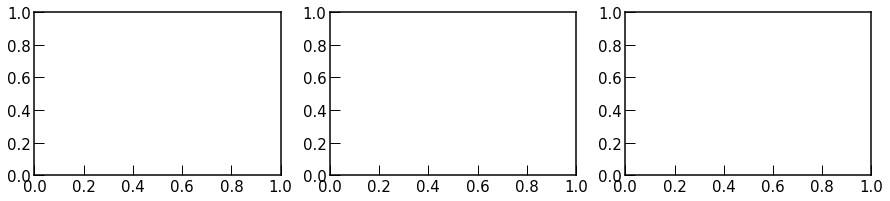

In [760]:
fig, (axs, axs2, axs3) = plt.subplots(1,3, figsize=(15,3))
axs.scatter(red_run_16.T[0], red_run_16.T[1], color=colors, s=10)
axs2.scatter(red_run_16_k.T[0], red_run_16_k.T[1], color=colors, s=10)
axs3.scatter(red_run_16_d.T[0], red_run_16_d.T[1], color=colors, s=10)
axs.xaxis.set_visible(False); axs.yaxis.set_visible(False)
axs2.xaxis.set_visible(False); axs2.yaxis.set_visible(False)
axs3.xaxis.set_visible(False); axs3.yaxis.set_visible(False)

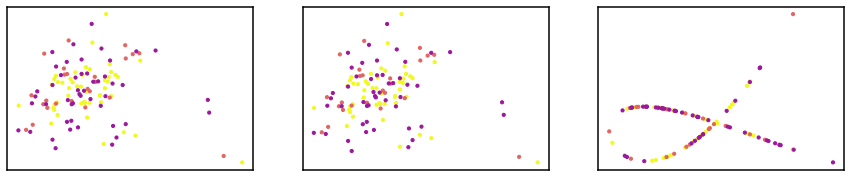

In [769]:
fig, (axs, axs2, axs3) = plt.subplots(1,3, figsize=(15,3))
axs.scatter(red_run_20_120_180_220.T[1], red_run_20_120_180_220.T[2], color=colors, s=10)
axs2.scatter(red_run_20_120_180_220_k.T[1], red_run_20_120_180_220_k.T[2], color=colors, s=10)
axs3.scatter(red_run_20_120_180_220_d.T[1], red_run_20_120_180_220_d.T[2], color=colors, s=10)
axs.xaxis.set_visible(False); axs.yaxis.set_visible(False)
axs2.xaxis.set_visible(False); axs2.yaxis.set_visible(False)
axs3.xaxis.set_visible(False); axs3.yaxis.set_visible(False)

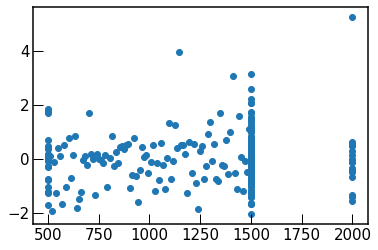

In [690]:
fig, axs = plt.subplots()

axs.scatter(Ts, red_run_16_k.T[1])

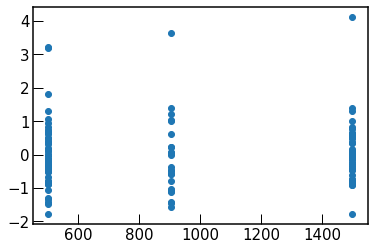

In [716]:
fig, axs = plt.subplots()

axs.scatter(Ts, red_run_20_120_180_220_k.T[1])

In [725]:
len(run_16)

241

In [727]:
run_16[50].info, Ts[50]

({'rundir': 'run_16',
  'gap18_energy': -10402.158158684473,
  'gap18_virial': array([[  2.09663849,  -2.04802597,  -6.96140321],
         [ -2.04802597,   3.23821051,  -1.65943298],
         [ -6.96140321,  -1.65943298, -11.78792909]]),
  'timestep': 50.0,
  'config_type': 'melt-quench'},
 904.040404040404)

In [742]:
cns = [cn_count(i, r=2.5)[0].argmax() for i in run_16]

In [743]:
len(cns); len(Ts)

241

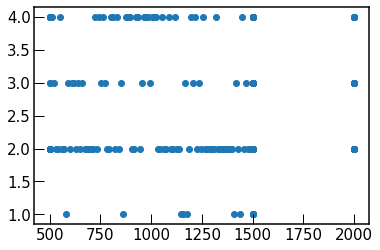

In [744]:
fig, axs = plt.subplots()

axs.scatter(Ts, cns)

In [436]:

pca.fit(k_test)
red = pca.fit_transform(k_test)

In [312]:
pca.fit(k_mp_mq1k)
red_mp_mq1k = pca.fit_transform(k_mp_mq1k)

In [332]:
pca.fit(k_mq1k)
red_mq1k = pca.fit_transform(k_mq1k)

In [437]:
pca.fit(k_test_zeta1)
red_zeta1 = pca.fit_transform(k_test_zeta1)

In [456]:
pca.fit(d_sq)
red_d_sq = pca.fit_transform(d_sq)

In [771]:
cm = mpl.cm.magma
norm = max(g18PQ1ks_rand_all_json['f_PressAve'])
colors = [cm(i/norm) for i in g18PQ1ks_rand_all_json['f_PressAve']]
# symbols = ['^']*

 Appears to be very uniform except w.r.t. pressure -> new data not useful, as observed/
 Could the issue be with selecting based on configuration-averaged SOAPs (1000-atoms systems -> average behaviour only captured). 

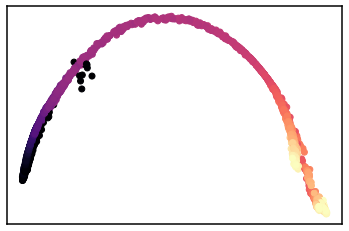

In [772]:
fig, axs = plt.subplots()

axs.scatter(red.T[0], red.T[1], color=colors)
           
axs.xaxis.set_visible(False); axs.yaxis.set_visible(False)

In [11]:
k_test_s3_at = calc_similarity(g18PQ1ks_rand[0], descriptor=\
                              'soap average=F l_max=6 n_max=12 atom_sigma=0.3 \
                          cutoff=5.0 cutoff_transition_width=1.0 \
                          central_weight=1.0'
                              )

(251, 1000, 547)


In [16]:
k_test_s3_c10 = calc_similarity(g18PQ1ks_rand[0], descriptor=\
                              'soap average=T l_max=6 n_max=12 atom_sigma=0.3 \
                          cutoff=10.0 cutoff_transition_width=1.0 \
                          central_weight=1.0'
                              )

(251, 1, 547)


In [ ]:
k_test_s3_at_flat = k_test_s3_at.reshape(251000, 547)

In [17]:
pca = decomposition.PCA(n_components=2, svd_solver='full')
pca.fit(k_test_s3_c10)
red_s3 = pca.fit_transform(k_test_c10)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
k_test_at = calc_similarity(flatten(g18PQ1ks_rand), descriptor=\
                            'soap average=F l_max=6 n_max=12 atom_sigma=1.0 \
                          cutoff=5.0 cutoff_transition_width=1.0 \
                          central_weight=1.0')

zeta=1 doesn't make much of a difference

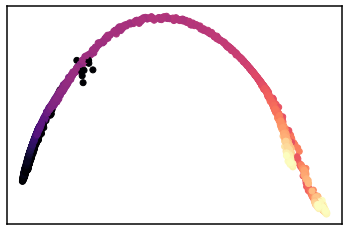

In [438]:
fig, axs = plt.subplots()

axs.scatter(red_zeta1.T[0], red_zeta1.T[1], color=colors)
           
axs.xaxis.set_visible(False); axs.yaxis.set_visible(False)

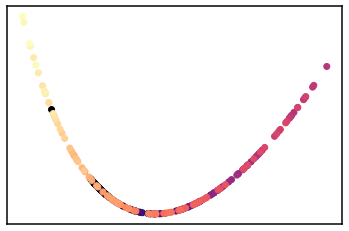

In [458]:
fig, axs = plt.subplots()

axs.scatter(red_d_sq.T[0], red_d_sq.T[1], color=colors[:251])
           
axs.xaxis.set_visible(False); axs.yaxis.set_visible(False)

In [325]:
ext_colors = colors+['RoyalBlue' for i in range(len(mq_sample_1k))] + ['ForestGreen' for i in range(len(mp_db_GAP18labelled_train))]

More diversity apparent in the materials-project crystals - in green below 

In [ ]:
fig, axs = plt.subplots()
axs.scatter(red_mp_mq1k.T[0],
           red_mp_mq1k.T[1],
           color=ext_colors,
            s=4
           )

axs.xaxis.set_visible(False); axs.yaxis.set_visible(False)

In [413]:
tot_ps = np.array([sum(i.info['GAP18_virial'][:3]) for i in flatten(g18PQ1ks_rand)] + \
[sum(i.info['gap18_virial'].diagonal()) for i in mq_sample_1k]  + \
[sum(i.info['gap18_virial'].diagonal()) for i in mp_db_GAP18labelled_train])*-1*160.218/3

In [414]:
tot_es = np.array([i.info['GAP18_energy']/len(i) for i in flatten(g18PQ1ks_rand)] + \
[i.info['gap18_energy']/len(i) for i in mq_sample_1k]  + \
[i.info['gap18_energy']/len(i) for i in mp_db_GAP18labelled_train])

In [415]:
mp_db_GAP18labelled_train[0].info

{'config_type': 'mp-1001113',
 'cutoff': 5.0,
 'nneightol': 1.2,
 'gap18_energy': -10411.259410263347,
 'gap18_virial': array([[ 0.01757834,  0.00039532, -0.00664968],
        [ 0.00039532,  0.04315108,  0.00241345],
        [-0.00664968,  0.00241345,  0.01966579]]),
 'energy': -10411.259410263347}

In [416]:
div = [len(flatten(g18PQ1ks_rand)), len(mq_sample_1k), len(mp_db_GAP18labelled_train)]
hist_cols = ['r']*div[0] + ['b']*div[1] + ['g']*div[2]

In [417]:
tot_es -= tot_es.min()

Coverage of energy space is broadest for the crystals, particularly at lower energies. Training on these alone, however, has not lead to a stable potential. Should try to combine the crystals with the PQ1k-rand to see how much improved this is

[(0.0, 0.6), Text(0.5, 0, 'Pressure / GPa')]

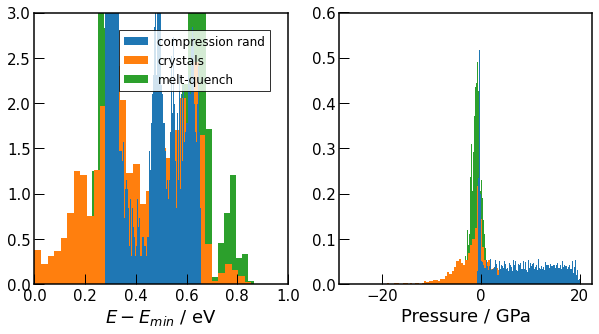

In [433]:
fig, (axs, axs2) = plt.subplots(1,2, figsize=(10,5))
labels = ['compression rand', 'crystals', 'melt-quench']

for i, val in enumerate([tot_es[0:div[0]], tot_es[div[1]:sum(div[0:3])], tot_es[div[0]:sum(div[0:2])]]):
    h1 = axs.hist(val,
                  bins=100, label=labels[i], zorder=-i, density=True)
axs.legend()
axs.set(xlim=(0,1), ylim=(0,3.0), xlabel='$E - E_{min}$ / eV')

for i, val in enumerate([tot_ps[0:div[0]], tot_ps[div[1]:sum(div[0:3])], tot_ps[div[0]:sum(div[0:2])]]):
    h2 = axs2.hist(val,
                  bins=100, label=labels[i], zorder=-i, density=True)

axs2.set(ylim=(0,0.6), xlabel='Pressure / GPa')

In [348]:
mq1k_colors = np.array([i.info['gap18_energy'] for i in mq_sample_1k])
norm = min(mq1k_colors)
mq1k_colors = cm(mq1k_colors/norm)

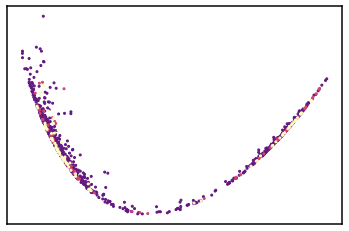

In [351]:
fig, axs = plt.subplots()
axs.scatter(red_mq1k.T[0],
           red_mq1k.T[1],
           color=mq1k_colors,
            s=4
           )

axs.xaxis.set_visible(False); axs.yaxis.set_visible(False)

# CUR selection
based on SOAP distances

Appears not to be deterministic, but analysis in rss shows that multiple runs combined with a histogram can show
at least some bias in the sampling. Would be good to compare to some other selection methods

In [295]:
k_test.shape

(2510, 2510)

In [236]:
cur = CUR(200)
cur_comp = CUR(200)

In [214]:
cur.fit(k_test, c=251)
cur_comp.fit(k_test_compress, c=200)

CUR(max_k=200)

In [271]:
x = range(2,502,50)
max_ks = [CUR(i, n_iter=10, algorithm='arpack') for i in x]
for i in max_ks:
    i.fit(k_test_compress, 50)
    
inters = []
for i in max_ks:
    inters.append(len(
            np.intersect1d(i.column_indices_, max_ks[-1].column_indices_))/len(max_ks[-1].column_indices_))

In [268]:
rands = []
for i in max_ks:
    rands.append(len(
        np.intersect1d(np.random.randint(0, len(k_test_compress), l:=len(max_ks[-1].column_indices_)),
                       max_ks[-1].column_indices_)
                )/l)

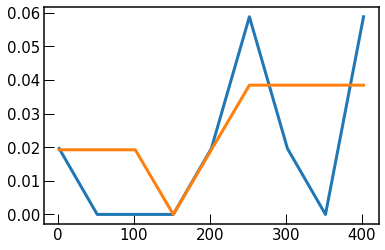

In [272]:
plt.plot(x[:-1], inters[:-1])
plt.plot(x[:-1], rands[:-1])

In [157]:
cur_comp.column_indices_

array([1715,  933,   36, 1927,  917, 1427,  911,  308,  326,   55,  750,
       1316, 1458, 1273,  305,  173,  121, 1642,  246,  449, 1646,  843,
        351, 1344, 1949,  868,   74,  367,  973,  302, 1825,  368, 1039,
        758, 1271, 1672, 1678,  380, 1346,  434,  856, 1057,  184,  978,
        277,  888,  300, 1877,  794,  186,  725, 1072, 1280, 1486,  501,
        990,  189, 1607,  285,  714,  647,  503, 1398,  881,  992,  288,
        686, 1495, 1099, 1212, 1003,   98,  195, 1485, 1392, 1696, 1188,
       1414,  726,  492,  807,   80,  808, 1890,  494,  221,  522, 1699,
        600, 1555,  787, 1490, 1402,  602,  402, 1155, 1557,  685, 1173,
       1583, 1154,  991, 1800,  803,  215, 1121, 1180,  297, 1784, 1613,
        573,  574,  526, 1521, 1149, 1723, 1569, 1395,  565, 1582,  563,
       1185, 1150,  202, 1572, 1745, 1595,  552, 1788, 1570, 1540,  586,
       1552, 1783, 1536, 1542,  579, 1135, 1543, 1775,  548, 1588,  800,
       1554, 1754,  597, 1752, 1765, 1593, 1780, 17

In [196]:
len(r)

2761

In [293]:
# append all the runs together
g18PQ1ks_rand_all_json = g18PQ1ks_rand_json[0].append(g18PQ1ks_rand_json[1:], ignore_index=True)

In [294]:
g18PQ1ks_rand_comp_json = g18PQ1ks_rand_json[0].loc[51000:].append(
    [i.loc[51000:] for i in g18PQ1ks_rand_json[1:]], ignore_index=True)

In [198]:
len(g18PQ1ks_rand_comp_json)

2211

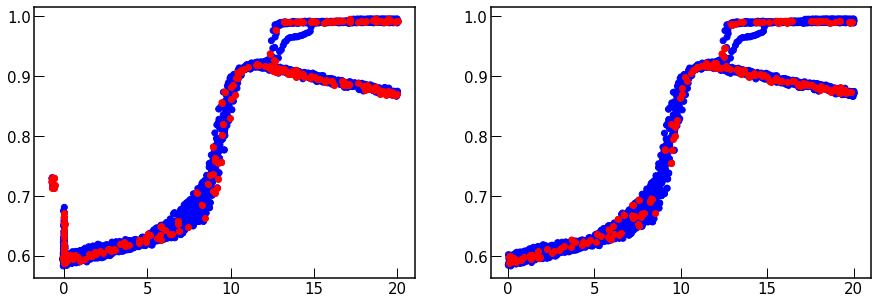

In [215]:
fig, (axs, axs2) = plt.subplots(1,2,figsize=(15,5))
r = g18PQ1ks_rand_all_json; r2 = g18PQ1ks_rand_comp_json
zs = np.ones(len(r))*0.5; zs2 = np.ones(len(r2))*0.5
cs = ['b']*len(r); cs2 = ['b']*len(r2)
for i in cur.column_indices_:
    cs[i] = 'r'; zs[i] = 1
for i in cur_comp.column_indices_:
    cs2[i] = 'r'; zs2[i] = 1
#     axs.axvline(r['f_PressAve'][i]/1e4, color='k', linewidth=0.5)

axs.scatter(r['f_PressAve']/1e4, r['sh'], color=cs)
axs.scatter(r['f_PressAve'][zs>0.6]/1e4, r['sh'][zs>0.6], color='r')

axs2.scatter(r2['f_PressAve']/1e4, r2['sh'], color=cs2)
axs2.scatter(r2['f_PressAve'][zs2>0.6]/1e4, r2['sh'][zs2>0.6], color='r')


In [216]:
def select_hist(r, cur, labels=None, bins=50, xtal='sh'):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.subplots_adjust(hspace=0.05)
    zs = np.ones(len(r))*0.5
    cs = ['b']*len(r)
    for i in cur.column_indices_:
        cs[i] = 'r'; zs[i] = 1

    ax1.scatter(r['f_PressAve']/1e4, r[xtal], color=cs, s=2)
    ax1.scatter(r['f_PressAve'][zs>0.6]/1e4, r[xtal][zs>0.6], color='r', s=3)
    ax2.hist(r['f_PressAve'][zs>0.6]/1e4, bins=bins)
    
    ax1.set(xlim=(-0.1,20.1), ylim=(0.2,1.0), ylabel='SOAP similarity')
    ax1.yaxis.set_label_coords(-0.1,0.25)
#     a = mpl.ticker.LinearLocator(4)
#     a.tick_values(0.4,1.0)
    ax1.set_yticks([0.4, 0.6, 0.8, 1.0])
    ax2.set(
        #xlim=(-0.1,20.1), ylim=(-0.3,0.3),
        xlabel='P / GPa')
    ax2.axhline(0, linewidth=1.5, linestyle='--', color='k')

    ax1.legend()
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    
    return fig

No handles with labels found to put in legend.
No handles with labels found to put in legend.


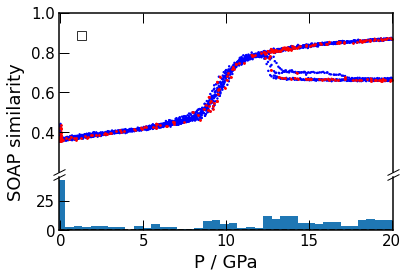

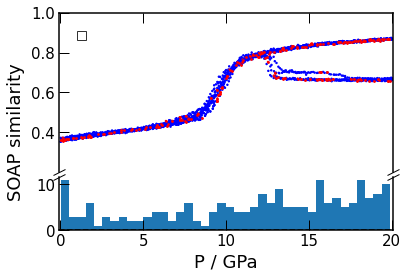

In [217]:
fig = select_hist(r, cur, xtal='fcc', bins=40); fig2 = select_hist(r2, cur_comp, xtal='fcc', bins=40)

In [79]:
r['f_PressAve'][r.index[i]]/1e4

72000    2.157865
72000    2.142167
72000    2.141856
72000    2.154994
72000    2.164736
72000    2.122763
72000    2.140935
72000    2.155549
72000    2.165812
72000    2.182521
Name: f_PressAve, dtype: float64

In [52]:
g18PQ1ks_rand_json[0].columns

Index(['file', 'timestep', 'CPU', 'Temp', 'f_TempAve', 'Press', 'f_PressAve',
       'f_PEAve_Atom', 'Volume', 'f_vAve', 'c_MSD[4]', 'GAP18_energy',
       'GAP18_virial', 'fcc', 'dia', 'hcp', 'bcc', 'sc', 'sh', 'bSn', 'Imma',
       'Cmca', 'fcc_fix_B', 'dia_fix_B', 'hcp_fix_B', 'bcc_fix_B', 'sc_fix_B',
       'sh_fix_B', 'bSn_fix_B', 'Imma_fix_B', 'Cmca_fix_B', 'cn'],
      dtype='object')

# Maxvol